In [1]:
import sys
import os
import shutil
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential, load_model
#from keras.layers import Conv2D,MaxPooling2D,\
#     Dropout,Flatten,Dense,Activation,\
#     BatchNormalization
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from google.colab import files
from google.colab import drive

In [2]:
drive.mount('/content/drive')
#load image data on collab
!mkdir -p ML_Project/dataset
!unzip -uq "/content/drive/MyDrive/ML_Project/CatsDogs.zip" -d "/content/ML_Project/dataset"

Mounted at /content/drive



##**Preprocessing**

In [3]:
#Params
#Paths
project_dir = "/content/ML_Project"
data_dir = project_dir + "/dataset/CatsDogs"
cats_dir = data_dir + '/Cats'
dogs_dir = data_dir + '/Dogs'
model_dir = '/content/drive/MyDrive/ML_Project/model/'
plots_dir = '/content/drive/MyDrive/ML_Project/plots/'
#Image params
Image_Width=128
Image_Height=128
Image_Channels=3
IMAGE_SHAPE = (Image_Width, Image_Height, Image_Channels)
IMAGE_SIZE = (Image_Width, Image_Height)

In [4]:
#check for corrupt exif data 
def remove_exif(data_dir):
  num = 0
  failed = 0
  for image_name in os.listdir(data_dir):
    path = os.path.join(data_dir, image_name)
    image = Image.open(path)
    try:
      if not image.getexif():
        num+=1
      data = list(image.getdata())
      image_without_exif = Image.new(image.mode, image.size)
      image_without_exif.putdata(data)
      image_without_exif.save(path)
    except:
      failed+=1
    return(print(f'Corrupt exif data where removed from {num} files. The process failed for {failed} files'))
    

#def downscale(Image_Size, img_path):
#  #resize images
#  for im in img_path:
#    img_path = os.path.join(img_path, img)
#    img = cv2.imread(img_path)
#    img = cv2.resize(img, Image_Size, interpolation = cv2.INTER_AREA)
#    return img


In [5]:
#add class to image names to create unique image ids in each folder
cats_filenames = ['0' + filename for filename in os.listdir(cats_dir)]
dogs_filenames = ['1' + filename for filename in os.listdir(dogs_dir)]
#rename and move images in same folder
for cat, dog in zip(cats_filenames, dogs_filenames):
  cat_src = cats_dir + '/' + cat[1:]
  dog_src = dogs_dir + '/' + dog[1:]
  cat_dst = data_dir + '/' + cat
  dog_dst = data_dir + '/' + dog
  shutil.move(cat_src, cat_dst)
  shutil.move(dog_src, dog_dst)
#now that dogs and cats have filename including class_id, we can remove original directories
os.rmdir(cats_dir)
os.rmdir(dogs_dir)

In [6]:
#remove corrupted files
import warnings
warnings.filterwarnings("ignore")
faulty_img = []
for img in os.listdir(data_dir):
  img_path = os.path.join(data_dir, img)
  try:
    img = Image.open(img_path)
  except:
    faulty_img.append(img_path)
    os.remove(img_path)
print(f'A total of {len(faulty_img)} corrupted files were spotted and removed')

A total of 2 corrupted files were spotted and removed


In [7]:
#check for corrput exif data
remove_exif(data_dir)

Corrupt exif data where removed from 1 files. The process failed for 0 files


In [8]:
#remove corrupt images
skipped_files = []
for filename in os.listdir(data_dir):
  file_path = os.path.join(data_dir, filename)
  try:
    fobj = open(file_path, "rb")
    is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
  finally:
    fobj.close()
  if not is_jfif:
    skipped_files.append(file_path)
    # Delete corrupted image
    os.remove(file_path)

print(f"Deleted {len(skipped_files)} images")

Deleted 1588 images


In [9]:
#explore images
file_size = []
file_dim = []
#img that throw error when opened in cv2 but work when fed to the data generator
skipped_files = []
#poor quality images
low_res_img = []
for img in os.listdir(data_dir):
  #read image
  img_path = os.path.join(data_dir, img)
  im = cv2.imread(img_path)
  try:
    #divide along the three dimensions of the ndarray to get pixel count
    size = im.size/3
    #shape = (num_height_pxl, num_width_pxl)
    shape = im.shape[:2]
    #store information
    if size<=50000:
      low_res_img.append(img_path)
    file_size.append(size)
    file_dim.append(shape)
  except:
    skipped_files.append(img)

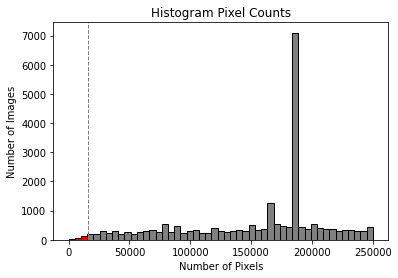

In [10]:
#plot num_pixels distribution of image datasets
pxl_count = [el for el in file_size]
#define range of pixels
minimum = min(pxl_count)
maximum = max(pxl_count)
range = maximum-minimum
frequency = 5000
#histogram
_,_,bins = plt.hist(pxl_count, color = 'grey', edgecolor = 'black',
                    bins = int(range/frequency))
for bin in bins:
  if bin.get_x() <= int(Image_Height*Image_Width//frequency*frequency):
    bin.set_facecolor('red')
# Add labels
plt.title('Histogram Pixel Counts')
plt.xlabel('Number of Pixels')
plt.ylabel('Number of Images')
plt.axvline(x=Image_Height*Image_Width, linestyle='--',linewidth=1, color='grey')
plt.show()

In [11]:
#visualize poor quality images
bad_im_size = []
bad_im_dim = [] 
for path in low_res_img:
  im = cv2.imread(path)
  size = im.size/3
  shape = im.shape[:2]
  bad_im_size.append(size)
  bad_im_dim.append(shape)
max_size = file_size.index(max(file_size))
min_size = file_size.index(min(file_size))
max_shape = file_dim[max_size]
min_shape = file_dim[min_size]

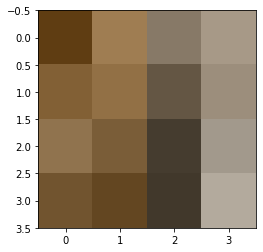

In [12]:
worst_img_path = low_res_img[bad_im_dim.index(min_shape)]
worst_img = cv2.imread(worst_img_path)
plt.imshow(worst_img)

In [13]:
#remove worst image and corrupt data
os.remove(worst_img_path)

In [14]:
#associate class id and category to images 
all_filenames = os.listdir(data_dir)
category = []
class_id = []
for el in all_filenames:
    if el[0]=='1':
        category.append('dog')
        class_id.append('1')
    elif el[0]=='0':
        category.append('cat')
        class_id.append('0')
    else:
        print(f'Anomalous filename in iteration {all_filenames.index(el)}')  

#create df
df = pd.DataFrame({
    'filename': all_filenames,
    'category': category,
    'class_id': class_id
})

In [15]:
'''
# create train and test split keeping ballanced classes
X = df['filename']
y = df['class_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
# get validation set from train set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)
'''
# create train and test split keeping ballanced classes
train_df, test_df = train_test_split(df[['filename', 'class_id']], test_size=0.10, random_state=42, stratify= df['class_id'])
# get validation set from train set
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42, stratify=train_df['class_id'])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [16]:
#move images to split set
train_path = data_dir + '/train/'
val_path = data_dir + '/val/'
test_path = data_dir + '/test/'
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
train = [shutil.move(data_dir + '/' + el, train_path + el) for el in list(train_df['filename'])]
val = [shutil.move(data_dir + '/' + el, val_path + el) for el in list(val_df['filename'])]
test = [shutil.move(data_dir + '/' + el, test_path + el) for el in list(test_df['filename'])]

In [17]:
#add image absolute paths to filenames
train_df['filename'] = train_path + train_df['filename'].astype(str)
val_df['filename'] = val_path + val_df['filename'].astype(str)
test_df['filename'] = test_path + test_df['filename'].astype(str)

In [18]:
'''
#get class proportion in each set
train_cats_count = (y_train == '0').sum().sum()
train_dogs_count = (y_train == '1').sum().sum()
val_cats_count = (y_val == '0').sum().sum()
val_dogs_count = (y_val == '1').sum().sum()
test_cats_count = (y_test == '0').sum().sum()
test_dogs_count = (y_test == '1').sum().sum()
'''

"\n#get class proportion in each set\ntrain_cats_count = (y_train == '0').sum().sum()\ntrain_dogs_count = (y_train == '1').sum().sum()\nval_cats_count = (y_val == '0').sum().sum()\nval_dogs_count = (y_val == '1').sum().sum()\ntest_cats_count = (y_test == '0').sum().sum()\ntest_dogs_count = (y_test == '1').sum().sum()\n"

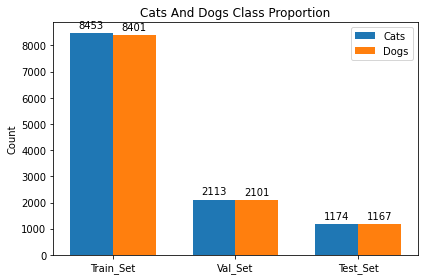

In [19]:
#get class proportion in each set
train_cats_count = len([el for el in os.listdir(train_path) if el[0]=='0'])
train_dogs_count = len([el for el in os.listdir(train_path) if el[0]=='1'])
val_cats_count = len([el for el in os.listdir(val_path) if el[0]=='0'])
val_dogs_count = len([el for el in os.listdir(val_path) if el[0]=='1'])
test_cats_count = len([el for el in os.listdir(test_path) if el[0]=='0'])
test_dogs_count = len([el for el in os.listdir(test_path) if el[0]=='1'])

#plot
labels = ['Train_Set', 'Val_Set', 'Test_Set']
cats = [train_cats_count, val_cats_count, test_cats_count]
dogs = [train_dogs_count, val_dogs_count, test_dogs_count]

label = np.array(labels)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cats, width, label='Cats')
rects2 = ax.bar(x + width/2, dogs, width, label='Dogs')

# Add text
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
ax.set_ylabel('Count')
ax.set_title('Cats And Dogs Class Proportion')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

##**Model**


###Primary Functions

In [20]:
#model builder
def CnnModel(architecture):
  '''
  Input: Model architecture with the following specifications:
          - input_shape (tuple of the form (w, h, channels))
          - out_channel (integer)
            n.b. these are used in the first CN block and are doubled for each subsequent block
          - conv_layers (integer number of convolutional layers)
          - fc_layers (integer number of dense layer)
          - dropout (either True or False)

  '''
  #model parameters
  input_shape, out_channels, conv_layers, fc_layers, dropout = architecture

  #build model
  cnn_model = Sequential([Conv2D(out_channels, 3, activation='relu', input_shape=input_shape),
                          BatchNormalization(),
                          MaxPooling2D(pool_size=(2,2))
                          ])
  if dropout:
    cnn_model.add(Dropout(0.25))

  if conv_layers > 1:
    CL = 1
    nth_out_channels = out_channels
    while CL <= conv_layers-1:
      nth_out_channels = nth_out_channels *2
      conv_block = Sequential([Conv2D(nth_out_channels, 3,activation='relu'),
                               BatchNormalization(),
                               MaxPooling2D(pool_size=(2,2))
                              ])
      if dropout:
        conv_block.add(Dropout(0.25))
      for layer in conv_block.layers:
        cnn_model.add(layer)
      CL+=1
    
  if fc_layers ==1:
    out_block = Sequential([GlobalAveragePooling2D(),
                            Dense(2, activation='softmax')
                            ])
  else:
    out_block = Sequential([Flatten()])
    num_fc = fc_layers-1
    output_dim = 512
    while num_fc > 1: 
      output_dim = output_dim*2
      num_fc-=1
    FC = 1
    while FC <= fc_layers-1:  
      out_block.add(Dense(output_dim,activation='relu'))
      out_block.add(BatchNormalization())
      if dropout:
        out_block.add(Dropout(0.5))
      output_dim = int(output_dim/2)
      FC+=1
    out_block.add(Dense(2,activation='softmax'))
  
  for layer in out_block.layers:
    cnn_model.add(layer)      
                        
  return cnn_model

In [21]:
CnnModel(((128, 128, 3), 32, 3, 3, True)).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [22]:
#data generator and loader function
def data_generator(df, data_path, set_type, image_size, batch_size, xy = ['filename', 'class_id']):

  x_col, y_col = xy

  if set_type in ['val', 'test']:
    datagen = ImageDataGenerator(rescale=1./255)

  
  elif set_type == 'train':
    datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

  else:
    print('Incorret specification for set_type argument: acceptable arguments are one of [train, test, val]')
    pass
  generator = datagen.flow_from_dataframe(df,
                                          data_path,
                                          x_col='filename',
                                          y_col='class_id',
                                          target_size=image_size,
                                          class_mode='categorical',
                                          batch_size=batch_size
                                          )
  return generator

In [23]:
#training function
def train_model(model, fit_generator_params, loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'], cp_dir = 'model/'):
  #define callbacks, learning rate, checkpoints
  patience = fit_generator_params['epochs']//10
  earlystop = EarlyStopping(patience = patience)
  learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
  checkpoint_path = cp_dir + 'cnn' + '.{epoch:02d}-{val_loss:.2f}.hdf5'
  cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=False,
                                save_best_only = True,
                                #save_freq=3*batch_size,
                                verbose=1)
  os.makedirs(cp_dir, exist_ok = True)
  callbacks = [earlystop,learning_rate_reduction, cp_callback]
  model.compile(loss=loss,
                  optimizer=optimizer,metrics=metrics)
  history = model.fit(
    fit_generator_params['data'], 
    epochs=fit_generator_params['epochs'],
    validation_data=fit_generator_params['validation_data'],
    validation_steps=len(val_df)//fit_generator_params['batch_size'],
    steps_per_epoch=len(train_df)//fit_generator_params['batch_size'],
    callbacks=callbacks
    ) 
  return history

###Secondary Functions

In [24]:
#secondary functions
def get_model_name(architecture):
  input_shape, out_channels, conv_layers, fc_layers, dropout = architecture
  if dropout:
    dropout = '_dropout'
  else:
    dropout = ''
  name = str(conv_layers)+'conv_' + str(fc_layers) + 'fc' + dropout
  return name

'''
def exclude_trained_models(options, models_dir):
  architecture_names = [get_model_name(architecture) for architecture in options]
  trained_models = [model_name for model_name in os.listdir(models_dir) if os.path.isdir(os.path.join(models_dir,model_name))]
  for architecture in options:
    name = get_model_name(architecture)
    if name in trained_models:
      index = architecture_names.index(name)
      options.pop(index)
  return options
'''
def exclude_trained_models(options, models_dir):
  architecture_names = [get_model_name(architecture) for architecture in options]
  trained_models = [model_name for model_name in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir,model_name))]
  new_models = list(set(architecture_names)-set(trained_models))
  indexes = [architecture_names.index(model) for model in new_models]
  options = [options[index] for index in indexes]
  return options


def save_plot_results(history, model_name, save_dir):
  os.makedirs(save_dir, exist_ok=True)
  #plot accuracy
  accuracy_plot = save_dir + 'acc_'+ model_name
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(accuracy_plot, bbox_inches='tight')
  plt.close()
  #plot loss
  loss_plot = save_dir + 'loss_' + model_name
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(loss_plot, bbox_inches='tight')
  plt.close()

##**Training**


###Params

In [25]:
#input params
BATCH_SIZE = 15
EPOCHS=30
#build data generators
train_generator = data_generator(df=train_df, data_path=train_path, set_type = 'train',image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
val_generator = data_generator(df=val_df, data_path=val_path, set_type = 'val',image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
test_generator = data_generator(df=test_df, data_path=test_path, set_type = 'test',image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

fit_generator_params = {}
fit_generator_params['data'] = train_generator
fit_generator_params['validation_data'] = val_generator
fit_generator_params['epochs'] = EPOCHS
fit_generator_params['batch_size'] = BATCH_SIZE
fit_generator_params['validation_steps'] = len(val_df)//BATCH_SIZE
fit_generator_params['steps_per_epoch'] = len(train_df)//BATCH_SIZE

Found 16854 validated image filenames belonging to 2 classes.
Found 4214 validated image filenames belonging to 2 classes.
Found 2341 validated image filenames belonging to 2 classes.


###Main

In [26]:
#define grid of parameters for model
input_shape = [IMAGE_SHAPE]
out_channels = [32]
conv_layers = [1,2,3,4]
fc_layers = [1,2,3,4]
dropout = [True, False]
grid = [input_shape, out_channels, conv_layers, fc_layers, dropout]
options = list(itertools.product(*grid))
all_options = [comb for comb in options if comb[2] >= comb[3]]
#update model dirs
delta_options = exclude_trained_models(all_options, model_dir)

In [27]:
delta_options

[((128, 128, 3), 32, 4, 3, False)]

In [28]:
#train models
for architecture in delta_options:
  name = get_model_name(architecture)
  model = CnnModel(architecture)
  cp_dir = model_dir + name +'/'
  print(f'Training starting for model {name}')
  history = train_model(model, fit_generator_params, cp_dir = cp_dir)
  save_plot_results(history, name, plots_dir)
  print(f'Training completed for model -{name}-. Weights saved at {cp_dir}')

Training starting for model 4conv_3fc
Epoch 1/30
1123/1123 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.6170
Epoch 1: val_loss improved from inf to 0.66996, saving model to /content/drive/MyDrive/ML_Project/model/4conv_3fc/cnn.01-0.67.hdf5
1123/1123 [==============================] - 147s 120ms/step - loss: 0.7200 - accuracy: 0.6170 - val_loss: 0.6700 - val_accuracy: 0.6486 - lr: 0.0010
Epoch 2/30
1123/1123 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.7233
Epoch 2: val_loss improved from 0.66996 to 0.57901, saving model to /content/drive/MyDrive/ML_Project/model/4conv_3fc/cnn.02-0.58.hdf5
1123/1123 [==============================] - 124s 111ms/step - loss: 0.5598 - accuracy: 0.7233 - val_loss: 0.5790 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 3/30
1123/1123 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.7701
Epoch 3: val_loss improved from 0.57901 to 0.45100, saving model to /content/drive/MyDrive/ML_Project/

##**Prediction**

In [29]:
def retrieve_best_model(cp_path):
  if os.path.isdir(cp_path):
    model_cp = os.listdir(cp_path)
    val_loss = [float('.'.join(name.split('-')[-1].split('.')[:2])) for name in model_cp]
    index = val_loss.index(min(val_loss))
    best_model = os.path.join(cp_path, model_cp[index])
  else: 
    best_model = None
  return best_model 

In [30]:
architecture_col = []
loss_col = []
accuracy_col = []
model_names = sorted(os.listdir(model_dir))
for name in model_names:
  cp_path = os.path.join(model_dir, name)
  best_model = retrieve_best_model(cp_path)
  if best_model:
    model =  load_model(best_model)
    loss, accuracy = model.evaluate(test_generator, verbose=0)
    architecture_col.append(name)
    loss_col.append(loss)
    accuracy_col.append(accuracy)

In [31]:
df = pd.DataFrame(list(zip(architecture_col, accuracy_col, loss_col)),
               columns =['Architecture', 'Accuracy', 'Loss'])
df.head(20)

,Architecture,Accuracy,Loss
0,1conv_1fc,0.650150,0.627960
1,1conv_1fc_dropout,0.616403,0.641317
2,2conv_1fc,0.673644,0.627020
3,2conv_1fc_dropout,0.753097,0.522974
4,2conv_2fc,0.891072,0.283915
5,2conv_2fc_dropout,0.879539,0.304324
6,3conv_1fc,0.920974,0.208715
7,3conv_1fc_dropout,0.738146,0.531472
8,3conv_2fc,0.924818,0.202043
9,3conv_2fc_dropout,0.864161,0.332816


In [ ]:
def zero_one_loss(df):
  '''
  Input: pandas df with True Class column and Predict Class column
  '''
  #cast columns
  df['pred_class_id'] = df['pred_class_id'].astype('int')
  test_df['class_id'] = df['class_id'].astype('int')
  #compute loss
  n = len(df)
  loss_value = np.where(test_df['class_id'] != test_df['pred_class_id'], 1, 0)
  loss = sum(loss_value)/n
  #loss = sum(np.where(test_df['class_id'] != test_df['pred_class_id'], 1, 0))/n
  accuracy = 1-loss
  return loss, accuracy

In [ ]:
model_performances = {}
for cp in os.listdir(model_dir):
  cp_path = os.path.join(model_dir, cp)
  best_model = retrieve_best_model(cp_path)
  if best_model:
    model =  load_model(best_model)
    model_name = best_model.split('/')[-2]
    #predict on test
    predict = model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))
    test_df['pred_class_id'] = np.argmax(predict, axis=-1)
    test_df['pred_class_id'] = test_df['pred_class_id'].astype('int')
    test_df['class_id'] = test_df['class_id'].astype('int')
    #compute loss
    loss, accuracy = zero_one_loss(test_df)
    performances = {}
    performances['loss'] = loss
    performances['accuracy'] = accuracy
    model_performances[model_name] = performances


167/167 [==============================] - 40s 240ms/step


In [ ]:
#collect best model weights from each architecture
model_weights = []
for dir in os.listdir(model_dir):
  dir_path = os.path.join(model_dir, dir)
  files = [] 
  if os.path.isdir(dir_path):
    for file in os.listdir(dir_path):
      model_path = os.path.join(dir_path , file)
      files.append(model_path)
    #only append the last (best) model  
    model_weights.append(files[-1])
model_weights = sorted(model_weights)
model_weights

['/content/drive/MyDrive/ML_Project/model/1conv_1fc/cnn.10-0.62.hdf5',
 '/content/drive/MyDrive/ML_Project/model/1conv_1fc_dropout/cnn.03-0.64.hdf5',
 '/content/drive/MyDrive/ML_Project/model/2conv_1fc/cnn.04-0.61.hdf5',
 '/content/drive/MyDrive/ML_Project/model/2conv_1fc_dropout/cnn.10-0.52.hdf5',
 '/content/drive/MyDrive/ML_Project/model/2conv_2fc/cnn.13-0.31.hdf5',
 '/content/drive/MyDrive/ML_Project/model/2conv_2fc_dropout/cnn.11-0.37.hdf5',
 '/content/drive/MyDrive/ML_Project/model/3conv_1fc/cnn.11-0.31.hdf5',
 '/content/drive/MyDrive/ML_Project/model/3conv_1fc_dropout/cnn.05-0.52.hdf5',
 '/content/drive/MyDrive/ML_Project/model/3conv_2fc/cnn.09-0.24.hdf5',
 '/content/drive/MyDrive/ML_Project/model/3conv_2fc_dropout/cnn.06-0.36.hdf5',
 '/content/drive/MyDrive/ML_Project/model/3conv_3fc_dropout/cnn.01-0.60.hdf5',
 '/content/drive/MyDrive/ML_Project/model/4conv_1fc/cnn.07-0.21.hdf5',
 '/content/drive/MyDrive/ML_Project/model/4conv_1fc_dropout/cnn.11-0.29.hdf5',
 '/content/drive/MyDr

In [ ]:
model_performances

{'1conv_1fc': 0.4928,
 '1conv_1fc_dropout': 0.5,
 '2conv_1fc': 0.5028,
 '2conv_1fc_dropout': 0.5072,
 '2conv_2fc': 0.4852,
 '2conv_2fc_dropout': 0.498,
 '3conv_1fc': 0.5136,
 '3conv_1fc_dropout': 0.5108,
 '3conv_2fc': 0.5016,
 '3conv_2fc_dropout': 0.496,
 '3conv_3fc_dropout': 0.5048,
 '4conv_1fc': 0.5024,
 '4conv_1fc_dropout': 0.4984,
 '4conv_2fc_dropout': 0.4896,
 '4conv_3fc_dropout': 0.5028}

In [ ]:
test_df['pred_class_id'] = np.argmax(predict, axis=-1)
test_df['pred_category'] = np.where(test_df['pred_class_id'] == 1, 'dog', 'cat')
test_df['pred_class_id'] = test_df['pred_class_id'].astype('int')
test_df['class_id'] = test_df['class_id'].astype('int')

,filename,class_id,pred_class_id,pred_category,category
0,/content/ML_Project/dataset/CatsDogs/test/1110...,1,0,cat,0
1,/content/ML_Project/dataset/CatsDogs/test/1377...,1,1,dog,1
2,/content/ML_Project/dataset/CatsDogs/test/0390...,0,0,cat,0
3,/content/ML_Project/dataset/CatsDogs/test/1899...,1,1,dog,1
4,/content/ML_Project/dataset/CatsDogs/test/1113...,1,0,cat,0
